In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os, re, sys, math
sys.path.insert(0, '/home/paul/language-ident-from-speech/misc')
from get_results import parse_no_language
from os.path import join, exists
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

In [10]:
def add_f1_data_normal(df):
    f1_df = pd.DataFrame(columns=["expname", "f1_3s", "f1_10s", "f1_30s"])
    n = len(df)
    langs = []
    for i in range(n):
        result_row = [df["expname"].iloc[i]]
        target_lang = df["excluded_languages"].iloc[i]
        langs.append(target_lang)
        if target_lang == "ALL":
            continue
        for secs in ["3s", "10s", "30s"]:
            col = "classification_" + secs
            class_path = df[col][i]
            if class_path != "blank":
                prec, recall, f1 = calculate_f_score(class_path, target_lang, beta=1)
                result_row.append(f1)
            else:
                result_row.append("none")
        f1_df.loc[i] = result_row
    df = df.merge(f1_df, on="expname", how="outer")
    return df, langs

def calculate_f_score(classification_file, target_lang, beta=1):
    with open(classification_file, "r") as f:
        lines = f.readlines()
    true_pos_tl = 0
    false_pos_tl = 0
    true_neg_tl = 0
    false_neg_tl = 0
    for line in lines:
        entry = line.split()
        target = entry[0][:2]
        pred = entry[1]
        if target == target_lang and pred == target_lang:
            true_pos_tl += 1
        elif target == target_lang and pred != target_lang:
            false_neg_tl += 1
        elif target != target_lang and pred == target_lang:
            false_pos_tl += 1
        elif target != target_lang and pred != target_lang:
            true_neg_tl += 1
    precision = true_pos_tl / (true_pos_tl + false_pos_tl)
    recall = true_pos_tl / (true_pos_tl + false_neg_tl)
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return precision, recall, f_beta

def add_f1_baseline(df, langs):
    n = len(df)
    rows_list = []
    for i in range(n):
        expname = [df["expname"].iloc[i]][0]
        for target_lang in langs:
            result_row = [expname, target_lang]
            for secs in ["3s", "10s", "30s"]:
                col = "classification_" + secs
                class_path = df[col][i]
                if class_path != "blank":
                    prec, recall, f1 = calculate_f_score(class_path, target_lang, beta=1)
                    result_row.append(f1)
                else:
                    result_row.append("none")
            rows_list.append(result_row)
    f1_df = pd.DataFrame(rows_list, columns=["expname", "excluded_languages", "f1_3s", "f1_10s", "f1_30s"])
    df = df.merge(f1_df, on="expname", how="outer")
    return df

def generate_col_names():
    names = []
    for stat in ["mean", "std"]:
        for i in ["3", "10", "30"]:
            names.append(stat + "_f1_" + i + "s")
    return names

def average_baseline_df(df, step):
    df.sort_values("excluded_languages", inplace=True)
    df.reset_index(drop=True, inplace=True)
    numeric_cols = ["f1_3s", "f1_10s", "f1_30s"]
    cols = ["excluded_language"] + generate_col_names()
    rows = []
    n = len(df)
    for i in np.arange(0, n, step=step):
        lang = df["excluded_languages"][i]
        mean = df.loc[[i, i+1, i+2]][numeric_cols].mean()
        std = df.loc[[i, i+1, i+2]][numeric_cols].std()
        rows.append([lang] + list(mean) + list(std))
    avg_df = pd.DataFrame(rows, columns=cols)
    return avg_df

def average_ad_df(df):
    exp_list = get_expname_and_number(list(df["expname"]))
    cols = ["excluded_language"] + generate_col_names()
    numeric_cols = ["f1_3s", "f1_10s", "f1_30s"]
    rows = []
    for i, exps in enumerate(exp_list):
        excluded_lang = parse_no_language(exps[0])
        indices = []
        for exp in exps:
            idx = df[df["expname"] == exp].index[0]
            indices.append(idx)
        mean = df.loc[indices][numeric_cols].mean()
        if len(exps) > 1:
            std = df.loc[indices][numeric_cols].std()
        else:
            std = [0, 0, 0]
        rows.append([excluded_lang] + list(mean) + list(std))
    avg_df = pd.DataFrame(rows, columns=cols)
    return avg_df

def get_expname_and_number(expnames):
    exp_list = []
    found_names = []
    counts = []
    for exp in expnames:
        if exp[-2] == "_":
            name = exp[:-2]
        else:
            name = exp
        if name not in found_names:
            found_names.append(name)
            counts.append(1)
        else:
            idx = found_names.index(name)
            counts[idx] += 1
    for idx, name in enumerate(found_names):
        count = counts[idx]
        name_list = [name]
        if count > 1:
            for i in range(2, count + 1):
                new_name = name + "_" + str(i)
                name_list.append(new_name)
        exp_list.append(name_list)
    return exp_list
    
def get_combined_diff_error(baseline_val, lang_val, 
                            err_baseline, err_lang):
    D = baseline_val - lang_val
    err_d_sub = (err_baseline**2 + err_lang**2) / D**2
    return D/baseline_val * (math.sqrt(err_d_sub + (err_baseline/baseline_val)**2))

def calculate_diff_and_errors(base_row, lang_row):
    diffs = list(abs(base_row[0:3] - lang_row[0:3])/base_row[0:3])
    for i in range(3):
        baseline_val = base_row[i]
        err_baseline = base_row[i+3]
        lang_val = lang_row[i]
        err_lang = lang_row[i+3]
        err_combined = get_combined_diff_error(baseline_val, lang_val, 
                                              err_baseline, err_lang)
        diffs.append(err_combined)
    return diffs

def get_diffs_and_errors(baseline_df, lang_df):
    assert(len(baseline_df) == len(lang_df)), "Lengths of DFs do not match"
    rows_out = []
    cols = ["lang", "mean_diff_f1_3s", "mean_diff_f1_10s", 
            "mean_diff_f1_30s", "err_diff_f1_3s",
            "err_diff_f1_10s", "err_diff_f1_30s"]
    for index, row in baseline_df.iterrows():
        lang = row.excluded_language
        lang_row = lang_df.loc[lang_df["excluded_language"] == lang]
        assert len(lang_row) == 1, "Language row should be length 1"
        base_row = np.asarray(row.values[1:])
        lang_row = np.asarray(lang_row.values[0][1:])
        diff_row = calculate_diff_and_errors(base_row, lang_row)
        rows_out.append([lang] + diff_row)
    return pd.DataFrame(rows_out, columns=cols)

def setup_dfs(family):
    assert family in ["slavic", "all"], "Family should be 'lang' or 'all'"
    summary = pd.read_csv(join(os.getcwd(), "results", "ad_" + family + "_summary.csv"))
    baseline = summary[summary.excluded_languages == "ALL"]
    baseline.reset_index(drop=True, inplace=True)
    baseline.drop("excluded_languages", axis=1, inplace=True)
    ad_normal = summary[summary.excluded_languages != "ALL"]
    ad_normal.reset_index(drop=True, inplace=True)
    ad_normal, langs = add_f1_data_normal(ad_normal)
    baseline = add_f1_baseline(baseline, langs)
    
    avg_baseline = average_baseline_df(baseline,3)
    avg_normal_df = average_ad_df(ad_normal)
    avg_normal_df.sort_values("excluded_language", inplace=True)
    diff_df = get_diffs_and_errors(avg_baseline, avg_normal_df)
    
    return baseline, avg_baseline, ad_normal, avg_normal_df, diff_df

def get_strings(diff, seconds):
    sec_str = seconds + "s"
    if diff:
        return "lang", "mean_diff_f1_" + sec_str, "err_diff_f1_" + sec_str
    else:
        return "excluded_language", "mean_f1_" + sec_str, "std_f1_" + sec_str

def plot_error_bar(df, seconds, diff=True, size=(10, 5), 
                   savename=None, colour="#8172B2"):
    assert seconds in ["3", "10", "30"], "Invalid seconds length"
    plt.rcParams.update({'font.size':13})
    plt.figure(figsize=size)
    lang, mean_str, err_str = get_strings(diff, seconds)
    x = df[lang]
    y = df[mean_str]
    yerr = df[err_str]
    if diff:
        y = y * 100
        yerr = yerr * 100
        plt.ylabel("% decrease in F1 score")
    else:
        plt.ylabel("F1 score")
        plt.ylim((0,1))
    plt.bar(x, y, yerr=yerr,capsize=3, color=colour)
    plt.xlabel("Language")
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename + ".pdf", bbox_inches="tight")

def plot_multi_error_bar(df1, df2, seconds, lab1, lab2, size=(10, 5), 
                         savename=None, colour1="#4c72b0", colour2="#55A868"):
    assert seconds in ["3", "10", "30"], "Invalid seconds length"
    plt.rcParams.update({'font.size':13})
    plt.figure(figsize=size)
    lang, mean_str, err_str = get_strings(False, seconds)
    x_labels = df1[lang]
    y1 = df1[mean_str]
    y2 = df2[mean_str]
    yerr1 = df1[err_str]
    yerr2 = df2[err_str]
    plt.ylabel("F1 score")
    plt.ylim((0,1))
    
    
    bar_width = 0.3
    r1 = np.arange(len(df1))
    r2 = [x + bar_width for x in r1]
    plt.bar(r1, y1, yerr=yerr1,capsize=2, width=bar_width, 
            color=colour1, label=lab1)
    plt.bar(r2, y2, yerr=yerr2,capsize=2, width=bar_width,
            color=colour2, label=lab2)
    
    plt.legend(loc="lower right", facecolor="white")
    
    plt.xlabel("Language")
    plt.xticks(r1 + 0.15, x_labels)
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename + ".pdf", bbox_inches="tight")
    

In [11]:
all_base, all_avg_base, all_lang, all_avg_lang, all_diff = setup_dfs("all")

In [22]:
def make_stats(classification_file, languages, print_msg=False):
    with open(classification_file, "r") as f:
        # From lines like "GE001_33 KO" make simple pairs (true, predicted) like [GE, KO]
        classifications = np.array([[l.split()[0][:2], l.split()[1]] for l in f.readlines()])
        y_true = classifications[:, 0]
        y_pred = classifications[:, 1]
        conf_matrix = confusion_matrix(y_true, y_pred, labels=languages)

        if print_msg:
            # Pretty-printing the conf. matrix
            n = 4
            conf_matrix_nice = [languages[i].ljust(n) + " ".join([str(e).ljust(n) for e in row]) \
                for i, row in enumerate(conf_matrix)]
            conf_mtrx_msg = "Confusion matrix:\n{}{}\n{}".format(
                                " "*n,
                                " ".join([l.ljust(n) for l in languages]),
                                "\n".join(conf_matrix_nice))
            print(conf_mtrx_msg)
        return conf_matrix

seconds = "30"
languages = "AR BG CH CR CZ FR GE JA KO PL PO RU SP SW TH TU WU VN".split()
root_data_dir = join("/home", "paul", "gp-data")
results_path = join("exp", "results", "classification_" + seconds + "s")
base_classifications = [join(root_data_dir, "ad_all_tr_all", results_path),
                        join(root_data_dir, "ad_all_tr_all_2", results_path),
                        join(root_data_dir, "ad_all_tr_all_3", results_path)]
conf_1 = make_stats(base_classifications[0], languages)
conf_2 = make_stats(base_classifications[1], languages)
conf_3 = make_stats(base_classifications[2], languages)

In [26]:
mean_conf = np.mean( np.array([conf_1, conf_2, conf_3]), axis=0)

In [30]:
n = 4
conf_matrix_nice = [languages[i].ljust(n) + " ".join([str(int(e)).ljust(n) for e in row]) \
      for i, row in enumerate(mean_conf)]
conf_mtrx_msg = "Confusion matrix:\n{}{}\n{}".format(
                                " "*n,
                                " ".join([l.ljust(n) for l in languages]),
                                "\n".join(conf_matrix_nice))
print(conf_mtrx_msg)

Confusion matrix:
    AR   BG   CH   CR   CZ   FR   GE   JA   KO   PL   PO   RU   SP   SW   TH   TU   WU   VN  
AR  271  0    2    10   3    0    0    2    0    2    12   59   27   34   0    6    0    0   
BG  0    670  0    6    7    0    1    1    0    70   59   10   0    1    0    0    0    0   
CH  8    0    612  0    0    0    0    8    37   3    19   23   5    2    2    3    5    0   
CR  1    0    0    385  4    0    1    0    1    9    3    107  42   25   0    23   0    0   
CZ  1    7    1    7    761  1    2    1    0    217  4    7    0    7    9    0    0    0   
FR  0    0    0    2    0    790  0    0    0    22   0    16   0    4    0    1    0    0   
GE  43   0    20   5    41   0    755  4    0    29   51   64   0    9    0    46   0    0   
JA  0    1    25   0    8    1    1    235  54   0    1    3    2    2    2    8    0    0   
KO  0    0    19   1    8    0    0    20   669  0    1    3    52   21   0    5    1    0   
PL  1    4    0    1    1    0    0    0  

In [3]:

slavic_base, slavic_avg_base, slavic_lang, slavic_avg_lang, slavic_diff = setup_dfs("slavic")

/home/paul/miniconda3/envs/lid/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


ZeroDivisionError: division by zero

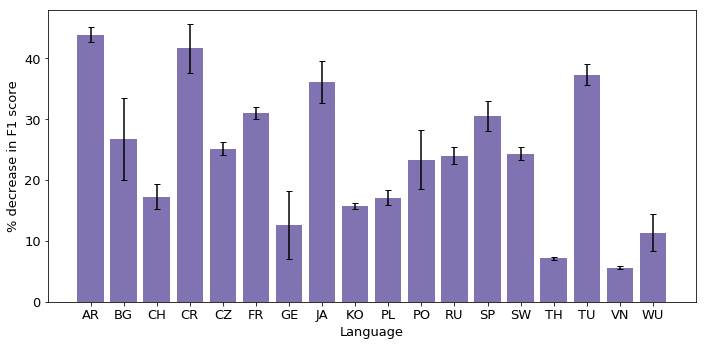

In [53]:
plot_multi_error_bar(all_avg_base, all_avg_lang, "30", 
                     "Baseline", "Adapted language",
                    savename="ad_all_comparison_30")
plot_error_bar(all_diff, "30", 
               savename="ad_all_diff_error_30")